## MP-3 Project - Analysis of ESC Semifinals running order and results

In [2]:
import pandas as pd, numpy as np, seaborn as sbn, matplotlib.pyplot as plt

from Modules import utils as utl
from Modules import data_exploration as de
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import sklearn.metrics as sm
import pickle

In [3]:
csv_file_path = 'Data/semifinalists_cleaned.csv'
eurovision_semi_df = utl.load_csv(csv_file_path, skiprows=0, encoding='windows-1252')

In [4]:
eurovision_semi_df

,year,semi_final,semi_draw_position,country,style,semi_place,semi_televote_points,semi_jury_points,semi_total_points
0,2023,1,1,Norway,Pop,6.0,102.0,NaN,102.0
1,2023,1,2,Malta,Pop,15.0,3.0,NaN,3.0
2,2023,1,3,Serbia,Pop,10.0,37.0,NaN,37.0
3,2023,1,4,Latvia,Rock,11.0,34.0,NaN,34.0
4,2023,1,5,Portugal,Pop,9.0,74.0,NaN,74.0
...,...,...,...,...,...,...,...,...,...
478,2009,2,15,Moldova,Traditional,5.0,NaN,NaN,106.0
479,2009,2,16,Albania,Dance,7.0,NaN,NaN,73.0
480,2009,2,17,Ukraine,Pop,6.0,NaN,NaN,80.0
481,2009,2,18,Estonia,Ballad,3.0,NaN,NaN,115.0


In [5]:
eurovision_semi_df.shape

(483, 9)

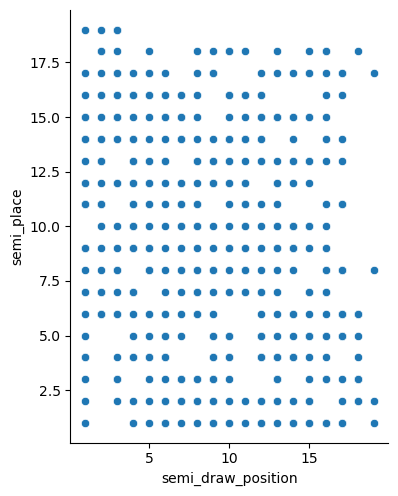

In [6]:
# visualise the features and the response using scatterplots
sbn.pairplot(eurovision_semi_df, x_vars=['semi_draw_position'], y_vars='semi_place', height=5, aspect=0.8)
plt.show()

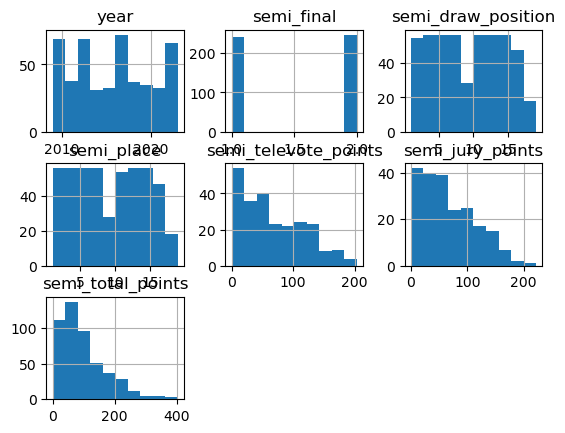

In [7]:
# histograms
hist = eurovision_semi_df.hist()

### Trying to figure out why there is a gap between 7.5 and 10 in semi_draw_position and semi_place

<Axes: >

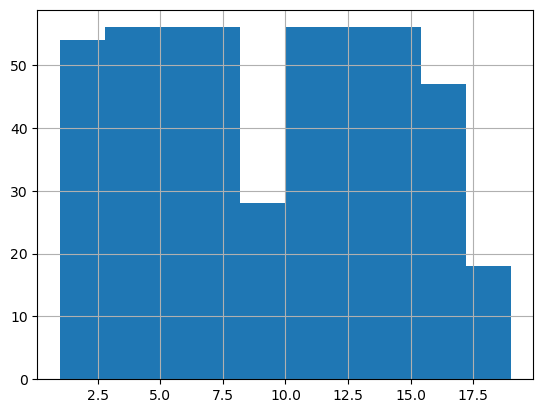

In [9]:
eurovision_semi_df['semi_draw_position'].hist()

In [10]:
not_semi_places = ['semi_final', 'country', 'style', 'semi_televote_points', 'semi_jury_points', 'semi_total_points']

In [11]:
semi_places = eurovision_semi_df.drop(columns=not_semi_places)

In [12]:
semi_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                483 non-null    int64  
 1   semi_draw_position  483 non-null    int64  
 2   semi_place          483 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 11.4 KB


In [13]:
# Count the number of occurrences of each place in 'semi_place'
place_counts = eurovision_semi_df['semi_place'].value_counts().sort_index()

# Display the counts
print(place_counts)


semi_place
1.0     28
2.0     28
3.0     28
4.0     28
5.0     28
6.0     28
7.0     28
8.0     28
9.0     28
10.0    27
11.0    27
12.0    28
13.0    28
14.0    28
15.0    28
16.0    26
17.0    21
18.0    14
19.0     4
Name: count, dtype: int64


In [14]:
# Count the number of occurrences of each place in 'semi_place'
place_counts = eurovision_semi_df['semi_draw_position'].value_counts().sort_index()

# Display the counts
print(place_counts)
# the reason for the 2 missing entries at semi_draw_position 1 - is because those 2 entries are missing semi_place data, so they are quite difficult to work around.

semi_draw_position
1     26
2     28
3     28
4     28
5     28
6     28
7     28
8     28
9     28
10    28
11    28
12    28
13    28
14    28
15    28
16    26
17    21
18    14
19     4
Name: count, dtype: int64


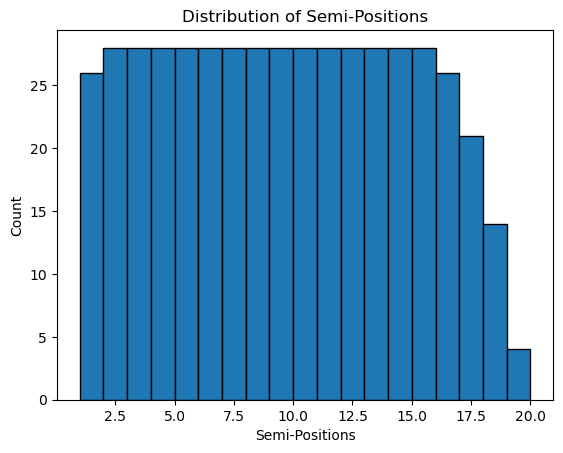

In [15]:
# Define custom bin edges to combat a skewed distribution in the intervals - as the positions will always be integers and never floating points - so the intervals are misleading
bin_edges = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Plot histogram with custom bin edges
plt.hist(eurovision_semi_df['semi_draw_position'], bins=bin_edges, edgecolor='black')
plt.title('Distribution of Semi-Positions')
plt.xlabel('Semi-Positions')
plt.ylabel('Count')
plt.show()


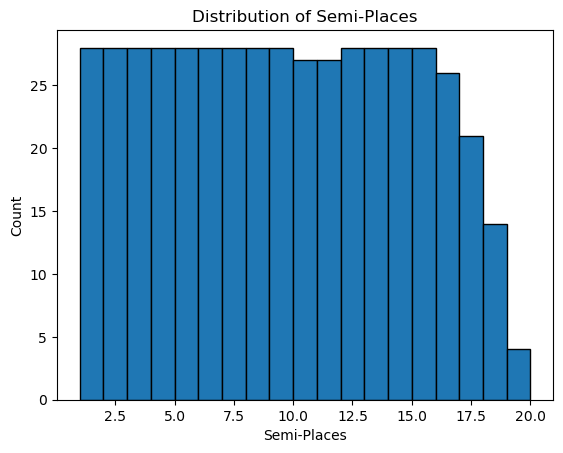

In [16]:
# Define custom bin edges to combat a skewed distribution in the intervals - as the placings will always be integers and never floating points - so the intervals are misleading
bin_edges = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Plot histogram with custom bin edges
plt.hist(eurovision_semi_df['semi_place'], bins=bin_edges, edgecolor='black')
plt.title('Distribution of Semi-Places')
plt.xlabel('Semi-Places')
plt.ylabel('Count')
plt.show()
# The two missing entries actually account for the small gap at 10 and 11 - the entries are Montenegro 2009 (11th) and Moldova 2010 (10th)

#### I have made more accurate bin distribution in the two histograms, which shows that there is a consistant pattern, with only 2 entries missing due to missing data in the dataset. So even though the initial histograms looked suspicious they were quite misleading.

### Back to exploration of data

In [19]:
eurovision_semi_df.isnull().sum()

year                      0
semi_final                0
semi_draw_position        0
country                   0
style                     0
semi_place                0
semi_televote_points    240
semi_jury_points        271
semi_total_points         0
dtype: int64

In [20]:
eurovision_semi_df.describe()

,year,semi_final,semi_draw_position,semi_place,semi_televote_points,semi_jury_points,semi_total_points
count,483.000000,483.000000,483.000000,483.000000,243.000000,212.000000,483.000000
mean,2015.645963,1.507246,9.231884,9.192547,68.263374,67.575472,97.788820
std,4.314998,0.500466,5.042975,5.069863,50.617148,47.545328,73.844662
min,2009.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2012.000000,1.000000,5.000000,5.000000,24.500000,26.750000,43.000000
50%,2016.000000,2.000000,9.000000,9.000000,54.000000,58.000000,77.000000
75%,2019.000000,2.000000,13.500000,13.500000,104.500000,98.250000,134.000000
max,2023.000000,2.000000,19.000000,19.000000,204.000000,222.000000,403.000000


<Figure size 600x400 with 0 Axes>

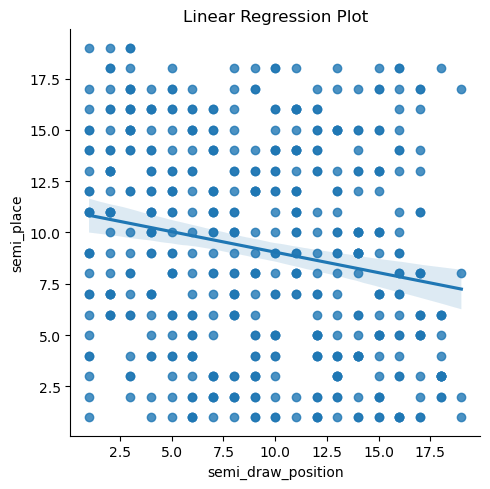

In [21]:
de.vs.lmplot(eurovision_semi_df, 'semi_draw_position', 'semi_place')
# the smaller the semi_place - the better

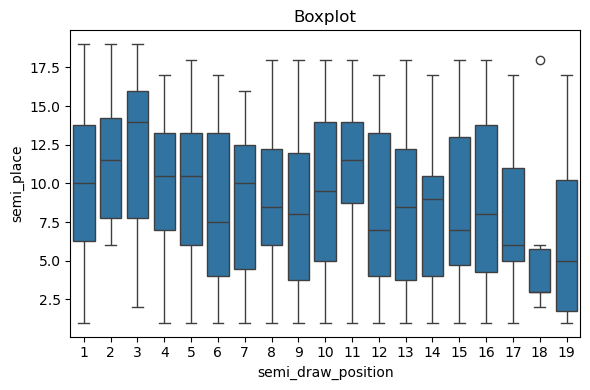

In [22]:
de.vs.boxplot(eurovision_semi_df, 'semi_draw_position', 'semi_place')

In [23]:
# reformat the Eurovision semifinal list to not include strings
eurovision_semi_num = ['year', 'semi_final', 'semi_draw_position', 'semi_televote_points', 'semi_jury_points', 'semi_total_points', 'semi_place']
eurovision_semi_df = eurovision_semi_df[eurovision_semi_num]

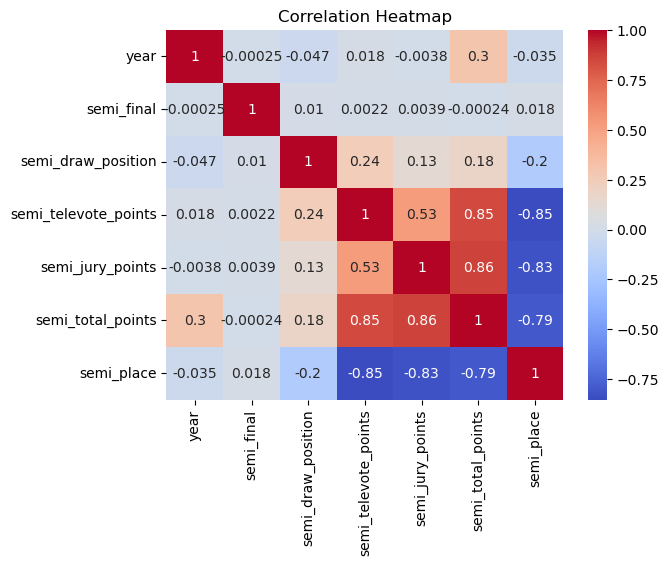

In [24]:
de.vs.correlation_heatmap(eurovision_semi_df)

### Separating the non numeral data from the data we want to train and test

In [26]:
# create a Python list of feature names
feature_cols = ['semi_final', 'semi_draw_position']

# use the list to select a subset of the original DataFrame
X = eurovision_semi_df[feature_cols]

# print the first 5 rows
X.head()

,semi_final,semi_draw_position
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


In [27]:
# select a Series from the DataFrame for y
y = eurovision_semi_df['semi_place']

# print the first 5 values
y.head()

0     6.0
1    15.0
2    10.0
3    11.0
4     9.0
Name: semi_place, dtype: float64

In [28]:
# check the type and shape of X
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(483, 2)


In [29]:
# check the type and shape of y
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(483,)


In [30]:
import sys
import os

# Use the current working directory instead of __file__
current_directory = os.getcwd()

# Add the path to the 'Modules' folder (adjust the path to reach the Modules folder)
sys.path.append(os.path.join(current_directory, 'Modules'))

# Now import the evalute function
import machine_learning
from machine_learning import *

### Training and testing

In [32]:
# training the data
X_train, X_test, y_train, y_test = machine_learning.prepare_data(eurovision_semi_df, 'semi_place')

In [33]:
# using Pipeline to combat NaN values in the points columns - and replacing them with a "mean" aggregated result instead.
model = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', LinearRegression())
])

In [34]:
model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('regressor', LinearRegression())])

In [35]:
reg = model.named_steps['regressor']

In [36]:
print("Intercept:", reg.intercept_)
print("Coefficients:", reg.coef_)

feature_names = X_train.columns
coef_table = list(zip(feature_names, reg.coef_))
for name, coef in coef_table:
    print(f"{name:30} {coef:>10.4f}")


Intercept: -536.9850842532123
Coefficients: [ 0.27376836  0.16946778 -0.03324651 -0.00484159  0.00925973 -0.05970829]
year                               0.2738
semi_final                         0.1695
semi_draw_position                -0.0332
semi_televote_points              -0.0048
semi_jury_points                   0.0093
semi_total_points                 -0.0597


####
Intercept: -536.99
 The intercept is the predicted semifinal place when all features are 0, which doesn't have much practical interpretation in this case. But in case it was - a negative value that big is reason for concern that the values aren't coherent with each other.

 Coefficients:
1. 'Year' (0.2738):
       A one-year increase is associated with a slight increase (0.27) in the predicted semifinal place. 
        This suggests that over the years, the rankings have slightly moved upwards on average - aka they have gotten worse.
2. 'Semi Final' (0.1695): 
    Moving from one semifinal to another is associated with a small increase (0.17) in the predicted place (so semi 2 is worse than semi 1), 
    reflecting possible differences in competition between the two semifinals. Perhaps because when the number of semifinalists are odd, one of the semifinals will have one more entry than the other - making it less likely to qualify from that semifinal.
3. 'Semi Draw Position' (-0.0332): 
    A later performance position (higher number) is associated with a slight improvement (lower `semi_place`) in ranking. 
    This supports the idea that later performances might be more memorable or have an advantage, potentially due to recency bias.
4. 'Semi Televote Points' (-0.0048): 
    As televote points increase, the predicted semifinal place improves (i.e., a better placement). 
    This is intuitive since more televote points would likely lead to a better semifinal result.
5. 'Semi Jury Points' (0.0093): 
    A higher number of jury points is associated with a worse semifinal place (higher `semi_place`), which is unexpected and suggests that higher jury points alone don't necessarily guarantee a better place in the semifinal. Perhaps the televote disagrees more strongly with jury favorites than juries do with televote favorites, leading to jury favorites performing slightly worse overall in the total result? As we also have to keep in mind the total result have in most of these recorded years (2009-2023) been 50%/50% jury/televote based - with the exception of 2023 and up - where the juries were removed from semifinals entirely, but still remaining at the same capacity in the final.
6. 'Semi Total Points' (-0.0597): 
    An increase in total points (combination of jury and televote) is associated with a better semifinal position 
    (lower `semi_place`), which is consistent with the idea that more points lead to a higher placement.

A negative coefficient generally represents a negative correlation with semi_place - which actually is good - because that means the value in question "negatively" impacts the place result (the number becomes lower) - as the lower the place number is - the better it is - as 1 is the best result here. So fx a high number of point should give you a low place number - like 3rd place, and vice versa a low number of points would give you a "high" placing like 15th - which would make it less likely to qualify.


In [38]:
correlation_matrix = eurovision_semi_df[['semi_jury_points', 'semi_televote_points', 'semi_total_points']].corr()
print(correlation_matrix)


                      semi_jury_points  semi_televote_points  \
semi_jury_points              1.000000              0.525732   
semi_televote_points          0.525732              1.000000   
semi_total_points             0.864943              0.845623   

                      semi_total_points  
semi_jury_points               0.864943  
semi_televote_points           0.845623  
semi_total_points              1.000000  


##### Jury points seems to align slightly more with the final result than the televote points

In [40]:
machine_learning.evaluate_model(model, X_test, y_test)

C:\Users\jejol\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 2.2032184691748617,
 'MSE': 7.044146662001728,
 'RMSE': 2.654081133274137,
 'R2': 0.682416644579799,
 'predictions': array([11.14262295, 11.32073626, 16.80366036,  9.25723564, 10.73536196,
        16.99148061,  8.03307926,  6.72927527, 10.50297199, -3.30510838,
        13.44816196, 10.0059701 , 13.22018753, 11.03573422, 13.0145813 ,
        11.94193802, 14.53087804, 12.63141632, 10.28023589, 11.1144583 ,
         9.05505635, 12.3137344 , 10.0820902 ,  7.17050573,  3.51739127,
         7.75504334,  6.59913239,  5.15069397, 10.83700297, 13.05106305,
         8.80088061,  5.3756916 , 16.73133795, 11.8496375 , 13.98503   ,
        12.35190483, 10.21075581, 13.43527737,  4.7234598 ,  8.73458413,
        17.39756022,  3.34500044,  6.09607514,  7.58658713, 11.16010474,
        15.17213214,  9.30337449, 10.06126987, 13.40883785,  6.83691762,
        14.58312451, 10.41204739,  8.18964832,  5.12225044, 17.41914793,
        11.39988546,  8.79941849,  7.65088487,  7.31152615,  5.29629843,


In [41]:
#machine_learning.save_model(model, 'semifinalpredictions')

In [42]:
load_model('semifinalpredictions')

Pipeline(steps=[('imputer', SimpleImputer()),
                ('regressor', LinearRegression())])

Mean Absolute Error (MAE) =  2.2032184691748617
Mean Squared Error (MSE) =  7.044146662001728
Root Mean Squared Error (RMSE) =  2.654081133274137
R2 (R-squared) score =  0.682416644579799
Explained variance score =  0.6847


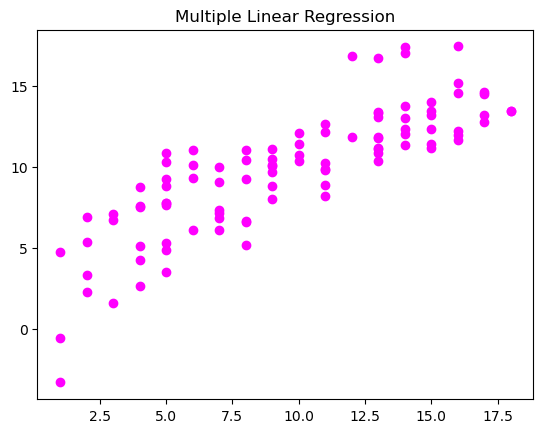

In [43]:

from sklearn import metrics

y_predicted = model.predict(X_test)

print("Mean Absolute Error (MAE) = ", metrics.mean_absolute_error(y_test, y_predicted))

print("Mean Squared Error (MSE) = ", metrics.mean_squared_error(y_test, y_predicted))


# calculate RMSE using scikit-learn
print("Root Mean Squared Error (RMSE) = ", np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))


# R-squared
r2_score = metrics.r2_score(y_test, y_predicted)
print ("R2 (R-squared) score = ", r2_score)
eV = round(sm.explained_variance_score(y_test, y_predicted), 4)
print('Explained variance score = ',eV )

# Visualise the regression results
plt.title('Multiple Linear Regression')
plt.scatter(y_test, y_predicted, color='magenta')
plt.show()




##### 
- MAE = the predicted semifinal places are off by approximately 2.2 places - so a 10th place here could be between 7.8 and 12.2 in the actual result - which is pretty close.
- MSE = A value of 7.04 indicates that, on average, the squared difference between predicted and actual places is 7.04, which in particular highlights the scale of this regression's errors due to the usage of squaring.
- RMSE = A value of 2.65 means that, on average, the predicted semifinal place is off by around 2.65 places - which is also still reasonable.
- Both R2 and the variance score are 0.68 - which means the model has covered 68% of the total variance in the semifinal results.

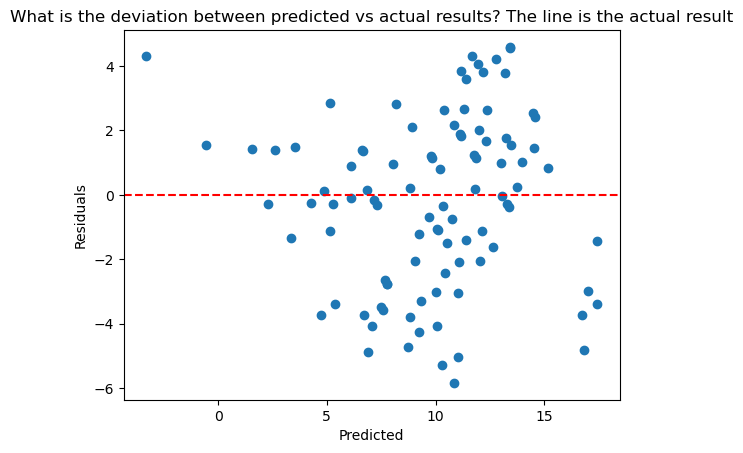

In [45]:
residuals = y_test - y_predicted
plt.scatter(y_predicted, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("What is the deviation between predicted vs actual results? The line is the actual result")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


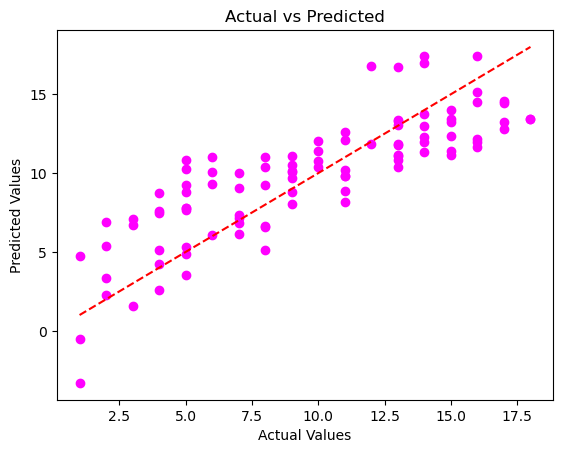

In [46]:
plt.scatter(y_test, y_predicted, color='magenta')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()


#### Since Eurovision results have a tendency to be quite unpredictable, we don't expect these predictions to be entirely accurate. But an variance score of 68% is pretty alright for a song contest with a small number of possible positions - in theory up until 26 - but ususally less than 20. That means of course that there is 32% of the result variance in the semifinals we don't account for. This can generally just stem from the upredictability of Eurovision results - like country-specific tendencies (diaspora voting, political voting, bloc-voting etc.), or just disrepancies between the juries and televotes.